http://docs.pymc.io/notebooks/GLM-hierarchical.html or a random effects model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind, linregress
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import scale

tracts_data_path = 'data/features.csv'

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dtypes = {'GEOID' : str,
          'place_geoid' : str,
          'state' : str,
          'county' : str}
df = pd.read_csv(tracts_data_path, encoding='utf-8', dtype=dtypes)
df = df.rename(columns={'GEOID' : 'tract'}).set_index('tract')
assert df.index.is_unique
df.head()

,land_area,place_geoid,place_name,total_pop,median_age,pct_hispanic,pct_white,pct_black,pct_single_fam_detached,med_rooms_in_house,...,pct_20_34,pct_burden,med_income_k,med_home_value_k,pct_white_change_2012_2015,clist_count,prop_count,bias_difference,bias_ratio,bias_log
tract,,,,,,,,,,,,,,,,,,,,,
01073000100,7549578,0107000,"Birmingham, AL",2970.0,32.2,4.6,17.1,78.5,70.5,5.1,...,20.8,60.4,24.359,68.4,1.4,3,2.150039,0.849961,1.395324,0.873518
01073000300,2093104,0107000,"Birmingham, AL",2494.0,36.5,18.0,4.6,67.2,32.6,4.5,...,25.1,53.4,20.425,65.3,-2.2,1,2.852092,-1.852092,0.350620,0.300564
01073000400,8001582,0107000,"Birmingham, AL",3437.0,30.6,0.7,7.9,90.8,89.7,5.7,...,25.1,74.7,21.759,60.7,2.5,2,2.120786,-0.120786,0.943046,0.664257
01073000500,4819145,0107000,"Birmingham, AL",3735.0,35.8,1.4,5.0,92.9,54.6,4.7,...,16.5,54.7,21.430,53.7,1.1,0,3.426167,-3.426167,0.000000,0.000000
01073000700,3520564,0107000,"Birmingham, AL",2562.0,25.4,2.5,0.0,97.7,56.9,5.1,...,21.4,77.3,15.833,52.4,-0.1,0,2.135412,-2.135412,0.000000,0.000000


## determine if tracts are over or under represented

In [3]:
overrepresent_var = 'bias_ratio'
overrepresent_value = 1

In [4]:
# divide data into two subsets: overrepresented and underrepresented (latter includes perfectly proportional)
mask = df[overrepresent_var] > 1
over = df[mask]
under = df[~mask]
print(len(over), len(under))

3078 9427


In [5]:
# make a dummy to indicate if tract is overrepresented
df['is_over'] = df[overrepresent_var].map(lambda x: 1 if x > 1 else 0)
df['is_over'].value_counts()

0    9427
1    3078
Name: is_over, dtype: int64

## *t*-tests and effect sizes for significant differences in variables

Divide the data into two subsets: overrepresented and underrepresented, then test if variables' means differ significantly between them.

In [6]:
# t-test: how do demographic vars differ between the two data sets?
variables = ['pct_hispanic', 'pct_white', 'pct_black', 'pct_single_fam_detached',
             'med_home_value_k', 'med_rooms_in_house', 'pct_built_before_1940',
             'pct_renting', 'renter_occupied_units_km', 'rental_vacancy_rate',
             'renter_household_size', 'med_income_k', 'mean_travel_time_work',
             'pct_commute_drive_alone', 'pct_below_poverty', 'median_age',
             'pct_nonrelatives_household', 'pct_same_residence_year_ago',
             'pct_bachelors_or_higher', 'pct_english_only', 'pct_foreign_born',
             'pop_density_k_km', 'pct_20_34', 'pct_burden', 'distance_to_center_km',
             'pct_white_change_2012_2015']
    
# effect size: as cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    return d

def test_variables(subset1, subset2, variables):
    test_results = {}
    for var in variables:
        a = subset1[var]
        b = subset2[var]
        t_statistic, p_value = ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit')
        diff = subset1[var].mean() - subset2[var].mean()
        d_value = cohen_d(x=a, y=b)
        test_results[var] = {'diff_mean' : round(diff, 2),
                             'p_value' : round(p_value, 3),
                             'cohen_d' : round(d_value, 2)}
    return test_results

In [7]:
# variables' effect sizes between over and underrepresented tracts
results = test_variables(over, under, variables)
effect_sizes = pd.DataFrame(results).T.sort_values('cohen_d', ascending=False)
effect_sizes

,cohen_d,diff_mean,p_value
pct_bachelors_or_higher,0.80,17.10,0.000
med_income_k,0.59,17.08,0.000
pct_white,0.58,16.97,0.000
pct_20_34,0.38,3.88,0.000
pct_english_only,0.37,9.24,0.000
pct_nonrelatives_household,0.36,2.19,0.000
med_home_value_k,0.33,74.51,0.000
median_age,0.10,0.68,0.000
rental_vacancy_rate,0.07,0.44,0.002
renter_occupied_units_km,0.06,173.34,0.012


In [8]:
variables_subset = ['pct_white', 'pct_nonrelatives_household', 'pct_below_poverty', 'pct_20_34',
                    'pct_bachelors_or_higher', 'med_income_k', 'mean_travel_time_work']

def significance(p):
    if p <= 0.01:
        return '^'
    elif p <= 0.05:
        return '*'
    else:
        return ''

city_results = {}
for city, group in df.groupby('place_name'):
    mask = group[overrepresent_var] > 1
    group_over = group[mask]
    group_under = group[~mask]
    group_results = test_variables(group_over, group_under, variables_subset)
    var_d = {k:'{}{}'.format(v['cohen_d'], significance(v['p_value'])) for k, v in group_results.items()}
    city_results[city] = var_d

In [9]:
city_effect_sizes = pd.DataFrame(city_results).T
city_effect_sizes.index = city_effect_sizes.index.map(lambda x: x.split(', ')[0])
#city_effect_sizes.sort_values(by='pct_white')
city_effect_sizes

,mean_travel_time_work,med_income_k,pct_20_34,pct_bachelors_or_higher,pct_below_poverty,pct_nonrelatives_household,pct_white
Atlanta,-0.55^,0.37,0.31,0.59^,-0.37*,0.21,0.49^
Austin,-0.27,0.44^,-0.02,0.72^,-0.26,0.17,0.7^
Baltimore,-0.61^,0.8^,1.05^,1.33^,-0.59^,0.84^,1.15^
Birmingham,-0.03,0.79^,0.01,0.71^,-0.87^,-0.08,0.5*
Boston,-0.95^,0.36,1.21^,1.36^,-0.01,0.93^,0.92^
Buffalo,-0.01,0.34,0.37,0.2,0.0,0.48,0.17
Charlotte,-0.09,0.23,0.3,0.35*,-0.31,0.13,0.16
Chicago,-0.9^,1.34^,1.36^,1.74^,-0.61^,1.22^,1.15^
Cincinnati,-0.79^,0.45*,0.68^,0.75^,-0.2,0.98^,0.62^
Cleveland,-0.33*,0.3,0.41*,0.42*,-0.27,0.25,0.26


In [10]:
# these variables have at least a small-medium effect size nationwide
vars_with_effect = effect_sizes[effect_sizes['cohen_d'].abs() >= 0.35].index

"Cohen suggested that d=0.2 be considered a 'small' effect size, 0.5 represents a 'medium' effect size and 0.8 a 'large' effect size. This means that if two groups' means don't differ by 0.2 standard deviations or more, the difference is trivial, even if it is statistically signficant."

Perhaps we can interpret small-medium effect size as absolute value 0.35 <= x < 0.5?

d is not affected by units/sizes. So income and income_k will have same d.

## Show a simple bivariate regression to explore relationship between variables

In [11]:
df = df.dropna()
len(df)

11965

In [12]:
# bivariate regression, show r^2 and p-value and plot
def bivariate_regress(y_var, x_var):

    # first regress y on x to get slope, intercept, r, p-value, and std error
    x = df[x_var]
    y = df[y_var]
    m, b, r, p, std_err = linregress(x=x, y=y)
    y_line = m * x + b
    
    title = '{} vs {}\n r^2={:.3f}, p={:.4f}'.format(y_var, x_var, r**2, p)

    # then scatterplot with bivariate line
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(x, y, s=2, marker='.', zorder=1)
    ax.plot(x, y_line, c='k', alpha=0.5, linewidth=0.5, zorder=2)
    ax.set_xlim((x.min(), x.max()))
    ax.set_ylim((y.min(), y.max()))
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    ax.set_title(title)
    plt.show()

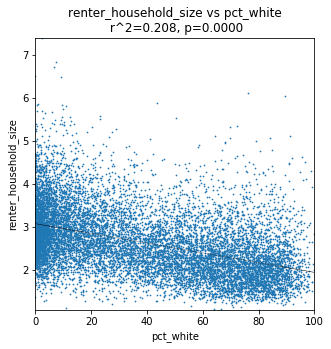

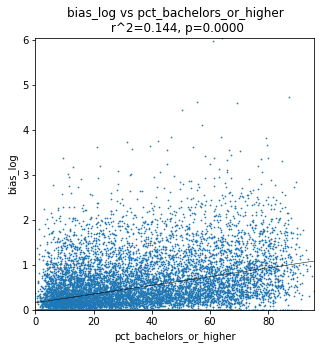

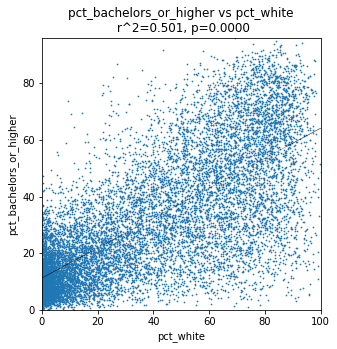

In [13]:
var_pairs = [('renter_household_size', 'pct_white'),
             ('bias_log', 'pct_bachelors_or_higher'),
             ('pct_bachelors_or_higher', 'pct_white')]

for y_var, x_var in var_pairs:
    bivariate_regress(y_var, x_var)

## Estimate regression models to predict Craigslist over- or under-representation

In [14]:
# here are our features
df.columns.sort_values()

Index(['bias_difference', 'bias_log', 'bias_ratio', 'centroid', 'clist_count',
       'count_renter_occupied_units', 'county', 'distance_to_center_km',
       'geometry', 'is_over', 'land_area', 'lat_city_center',
       'lng_city_center', 'mean_travel_time_work', 'med_home_value_k',
       'med_income_k', 'med_rooms_in_house', 'median_age', 'pct_20_34',
       'pct_bachelors_or_higher', 'pct_below_poverty', 'pct_black',
       'pct_built_before_1940', 'pct_burden', 'pct_commute_drive_alone',
       'pct_english_only', 'pct_foreign_born', 'pct_hispanic',
       'pct_nonrelatives_household', 'pct_renting',
       'pct_same_residence_year_ago', 'pct_single_fam_detached', 'pct_white',
       'pct_white_change_2012_2015', 'place_geoid', 'place_name',
       'pop_density_k_km', 'prop_count', 'rental_vacancy_rate',
       'renter_household_size', 'renter_occupied_units_km', 'state',
       'total_pop'],
      dtype='object')

In [15]:
# these have at least a small-medium effect size (see above)
vars_with_effect

Index(['pct_bachelors_or_higher', 'med_income_k', 'pct_white', 'pct_20_34',
       'pct_english_only', 'pct_nonrelatives_household',
       'pct_same_residence_year_ago', 'pct_below_poverty', 'pct_burden',
       'pct_hispanic', 'mean_travel_time_work', 'renter_household_size'],
      dtype='object')

In [16]:
# estimate a model across the full data set (all counties)
X = df[vars_with_effect]
y = df['bias_log']
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               bias_log   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     1041.
Date:                Wed, 28 Feb 2018   Prob (F-statistic):               0.00
Time:                        17:13:10   Log-Likelihood:                -9108.0
No. Observations:               11965   AIC:                         1.824e+04
Df Residuals:                   11953   BIC:                         1.833e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
pct_bachelors_or_h

In [17]:
# estimate a reduced model across the full data set (all counties)
formula = 'bias_log ~ med_income_k + pct_20_34 + pct_bachelors_or_higher + pct_white'
model = smf.ols(formula=formula, data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               bias_log   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     555.1
Date:                Wed, 28 Feb 2018   Prob (F-statistic):               0.00
Time:                        17:13:10   Log-Likelihood:                -9333.3
No. Observations:               11965   AIC:                         1.868e+04
Df Residuals:                   11960   BIC:                         1.871e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

#### and a regression for just one city

In [18]:
# subset data for a single city
place_name = 'New York, NY'
df_city = df[df['place_name']==place_name]
print(sum(df_city['bias_ratio']>1), sum(df_city['bias_ratio']<=1))

436 1546


In [19]:
# estimate a model for this single city
formula = 'bias_ratio ~ med_income_k + pct_20_34 + pct_bachelors_or_higher + pct_white'
model = smf.ols(formula=formula, data=df_city)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             bias_ratio   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     57.92
Date:                Wed, 28 Feb 2018   Prob (F-statistic):           2.82e-46
Time:                        17:13:10   Log-Likelihood:                -5114.5
No. Observations:                1982   AIC:                         1.024e+04
Df Residuals:                    1977   BIC:                         1.027e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

^^ multicollinearity can produce large standard errors in the related variables

## Logit models

In [20]:
# short-term fix before statsmodels 0.9 release fixes a bug
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [21]:
# predict whether or not tract is overrepresented on craigslist (yes/no)
formula = 'is_over ~ med_income_k + pct_20_34 + pct_bachelors_or_higher + pct_white '
model = smf.logit(formula=formula, data=df)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.507863
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                is_over   No. Observations:                11965
Model:                          Logit   Df Residuals:                    11960
Method:                           MLE   Df Model:                            4
Date:                Wed, 28 Feb 2018   Pseudo R-squ.:                 0.09874
Time:                        17:13:10   Log-Likelihood:                -6076.6
converged:                       True   LL-Null:                       -6742.3
                                        LLR p-value:                5.024e-287
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.9892      0.089    -33.539      0.000      -3.164   

In [22]:
# multicollinearity with demographic vars?

## Dimensionality reduction

### pca

In [23]:
y = df['bias_log']
X = df[['med_income_k', 'pct_20_34', 'pct_bachelors_or_higher',
        'pct_black', 'pct_white', 'renter_household_size']]
X = pd.DataFrame(scale(X.values), columns=X.columns)

In [24]:
# n dimensions
n = 4
pca = PCA(n_components=n)
pca.fit(X=X, y=y)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [25]:
# amount of variance that each component explains
pca.explained_variance_ratio_

array([0.50048251, 0.20813654, 0.1439126 , 0.09219049])

In [26]:
# cumulative variance explained
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3))

array([0.5  , 0.708, 0.852, 0.944])

In [27]:
labels = ['PC{}'.format(i+1) for i in range(n)]
pd.DataFrame(pca.components_, columns=X.columns, index=labels)

,med_income_k,pct_20_34,pct_bachelors_or_higher,pct_black,pct_white,renter_household_size
PC1,0.438006,0.161216,0.527873,-0.384541,0.510720,-0.307903
PC2,0.411967,-0.671057,-0.071567,-0.272181,0.056426,0.545507
PC3,-0.179404,0.566072,-0.147933,-0.600778,-0.014302,0.514154
PC4,0.508663,0.365654,0.370697,0.424794,-0.393725,0.366979


### factor analysis

In [28]:
# n dimensions
n = 4
fa = FactorAnalysis(n_components=n)
fa.fit(X=X, y=y)

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=4,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)

In [29]:
labels = ['PC{}'.format(i+1) for i in range(n)]
pd.DataFrame(fa.components_, columns=X.columns, index=labels)

,med_income_k,pct_20_34,pct_bachelors_or_higher,pct_black,pct_white,renter_household_size
PC1,0.827775,0.203305,0.944139,-0.550912,0.800432,-0.462160
PC2,0.437905,-0.650498,-0.137334,-0.130779,-0.081850,0.583907
PC3,0.117373,-0.113002,0.126077,0.622894,-0.340473,-0.165874
PC4,0.049549,0.475485,0.063203,-0.116763,-0.252858,0.374542
